In [41]:
'''
Description: Denoising autoencoders are learn to reconstruct the original image from noisy inputs. 
This acts as a regularization technique the model isn't just learning a simple input-output
'''


import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [42]:
# Encoder + Decoder classes
class Encoder(nn.Module): 

    def __init__(self, encoded_space_dim, fc2_input_dim): 
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        
        self.encoder_lin = nn.Sequential(
            nn.Linear(3*3*32, fc2_input_dim), 
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )

    def forward(self, x): 
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module): 

    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            # Why is there no activation function between the two fc layers around the latent dim? 
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 3*3*32), 
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x): 
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [43]:
loss_fn = torch.nn.MSELoss()
lr = 0.001
torch.manual_seed(0)

d = 4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print('Device: ', device)

encoder.to(device)
decoder.to(device)

Device:  mps


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [44]:
def add_noise(inputs, noise_factor=0.3): 
    # Create a noisy tensor the same size of the input (randn = random numbers from gaussian)
    noisy = inputs+torch.randn_like(inputs) * noise_factor

    # Limit the range to 0, 1
    noisy = torch.clip(noisy, 0.,1.)
    return noisy


In [45]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3): 
    encoder.train()
    decoder.train()

    train_loss = []

    for image_batch, _ in dataloader: 
        image_noisy = add_noise(image_batch, noise_factor=noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)

        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)

        loss = loss_fn(decoded_data, image_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    
    return np.mean(train_loss)

def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []

        for image_batch, _ in dataloader: 
            image_noisy = add_noise(image_batch, noise_factor=noise_factor)
            image_noisy = image_noisy.to(device)

            encoded_data = encoder(image_noisy)
            decoded_data = decoder(encoded_data)

            conc_out.append(decoded_data.cpu())
            conc_label.append(decoded_data.cpu())
        
        # Calculate the loss for all batches all at once
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

            

In [46]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

EPOCH  0

 EPOCH 1/30 	 train loss 0.123 	 val loss 0.000


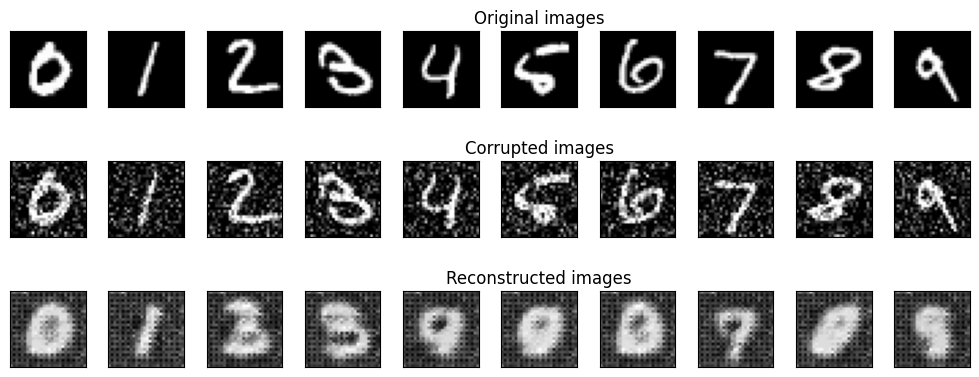

EPOCH  1

 EPOCH 2/30 	 train loss 0.054 	 val loss 0.000


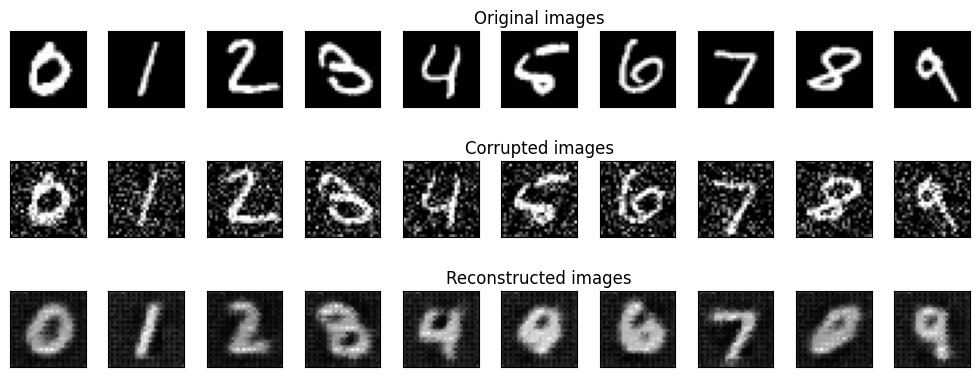

EPOCH  2

 EPOCH 3/30 	 train loss 0.042 	 val loss 0.000


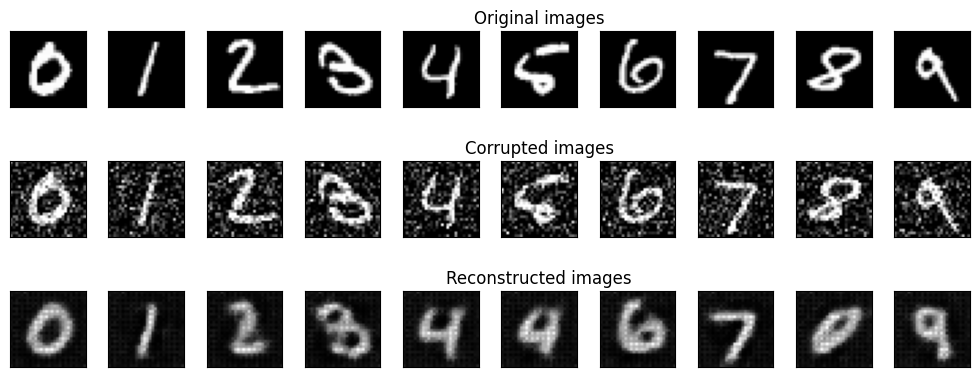

EPOCH  3

 EPOCH 4/30 	 train loss 0.036 	 val loss 0.000


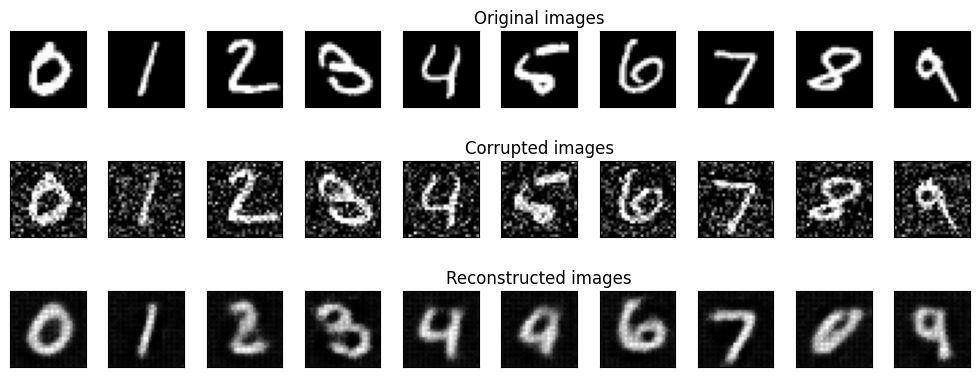

EPOCH  4

 EPOCH 5/30 	 train loss 0.033 	 val loss 0.000


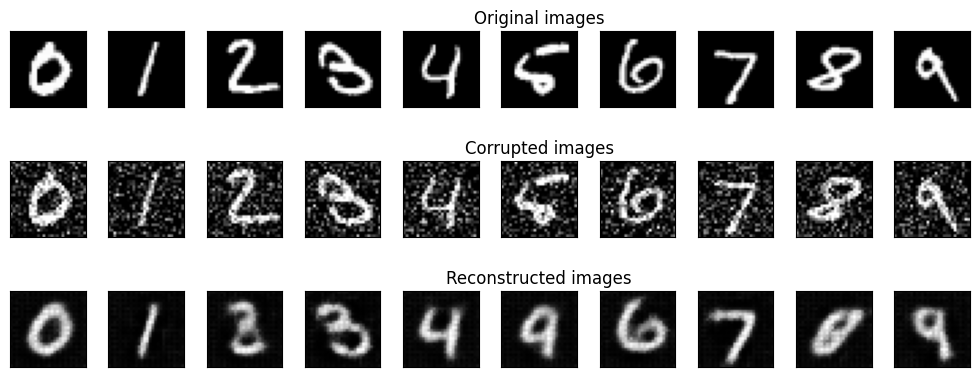

EPOCH  5

 EPOCH 6/30 	 train loss 0.032 	 val loss 0.000


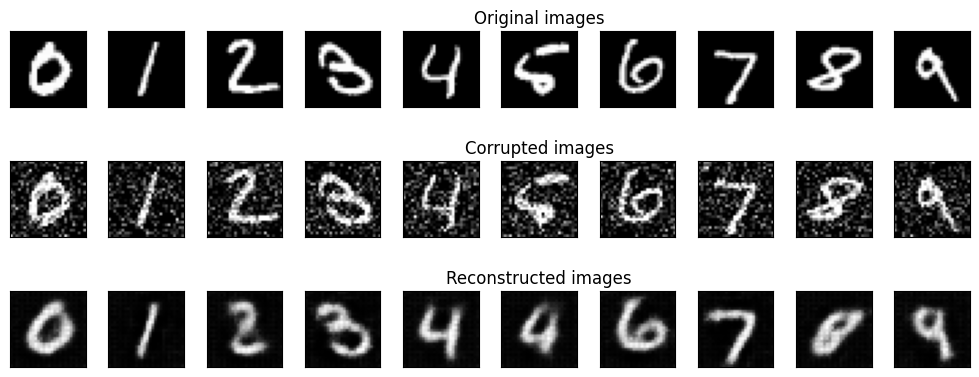

EPOCH  6

 EPOCH 7/30 	 train loss 0.031 	 val loss 0.000


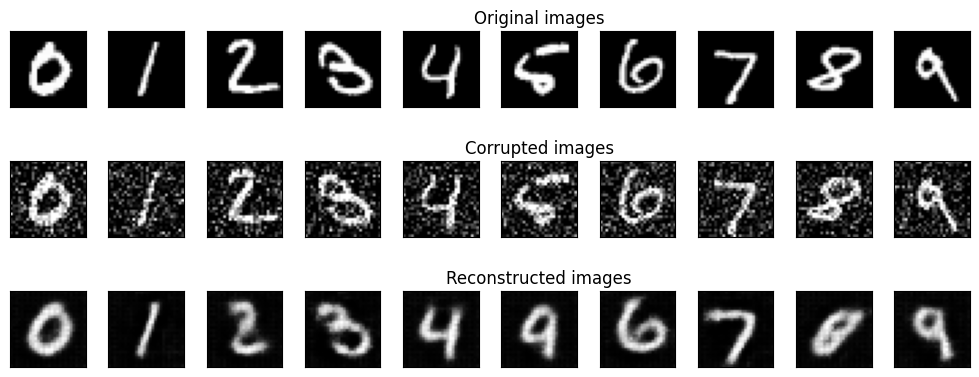

EPOCH  7

 EPOCH 8/30 	 train loss 0.031 	 val loss 0.000


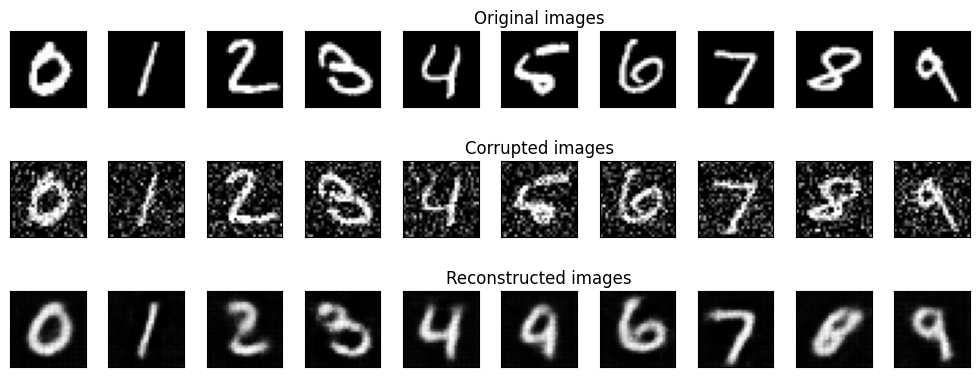

EPOCH  8

 EPOCH 9/30 	 train loss 0.030 	 val loss 0.000


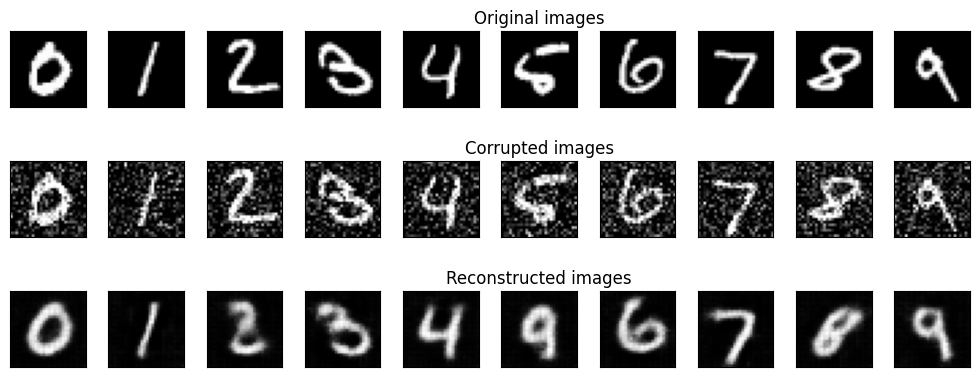

EPOCH  9

 EPOCH 10/30 	 train loss 0.030 	 val loss 0.000


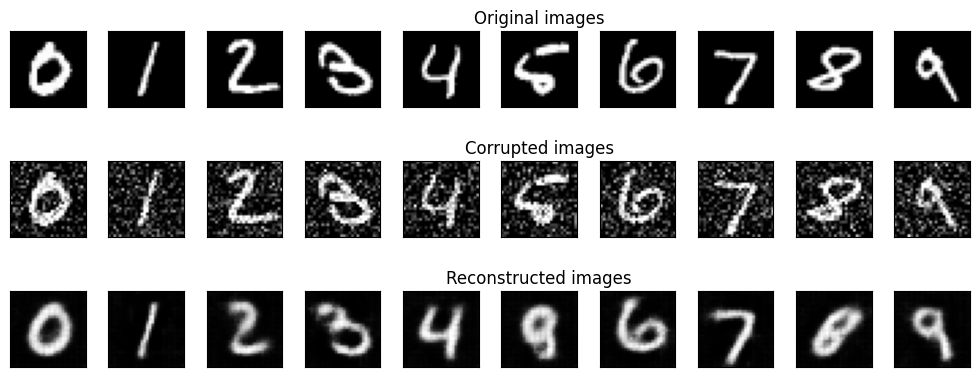

EPOCH  10

 EPOCH 11/30 	 train loss 0.029 	 val loss 0.000


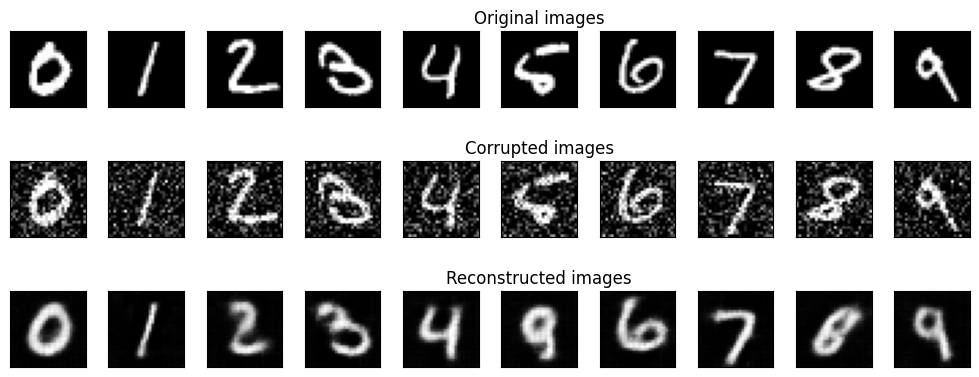

EPOCH  11

 EPOCH 12/30 	 train loss 0.029 	 val loss 0.000


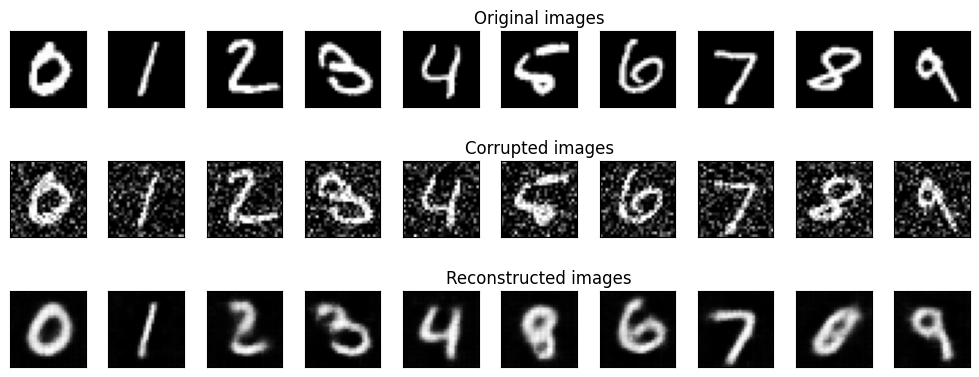

EPOCH  12

 EPOCH 13/30 	 train loss 0.029 	 val loss 0.000


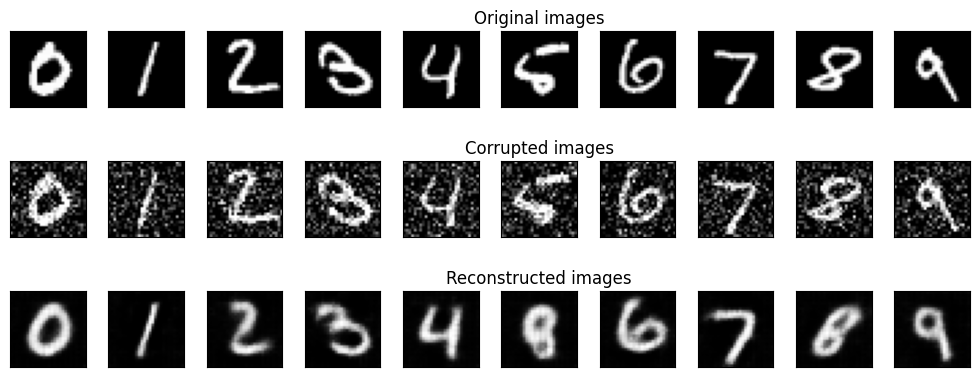

EPOCH  13

 EPOCH 14/30 	 train loss 0.029 	 val loss 0.000


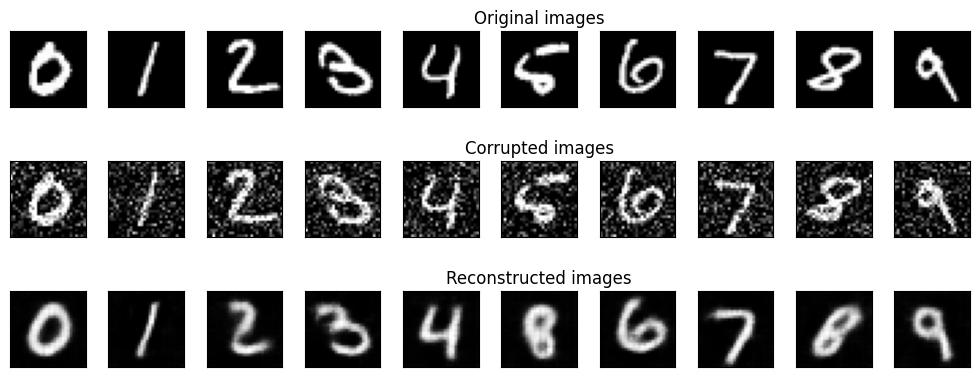

EPOCH  14

 EPOCH 15/30 	 train loss 0.028 	 val loss 0.000


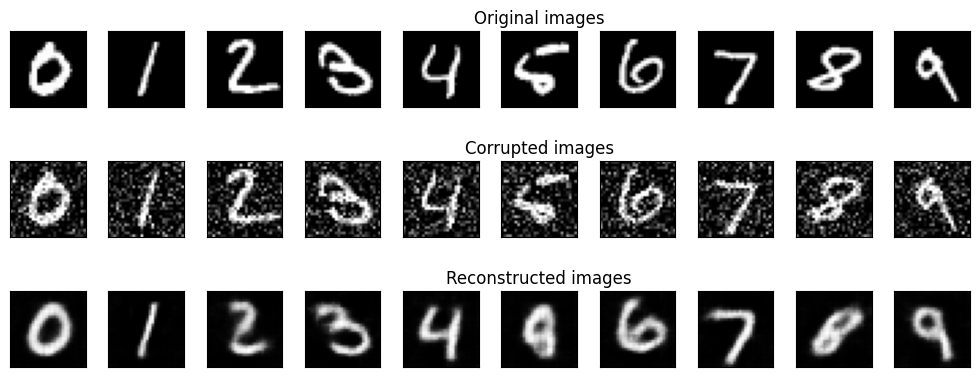

EPOCH  15

 EPOCH 16/30 	 train loss 0.028 	 val loss 0.000


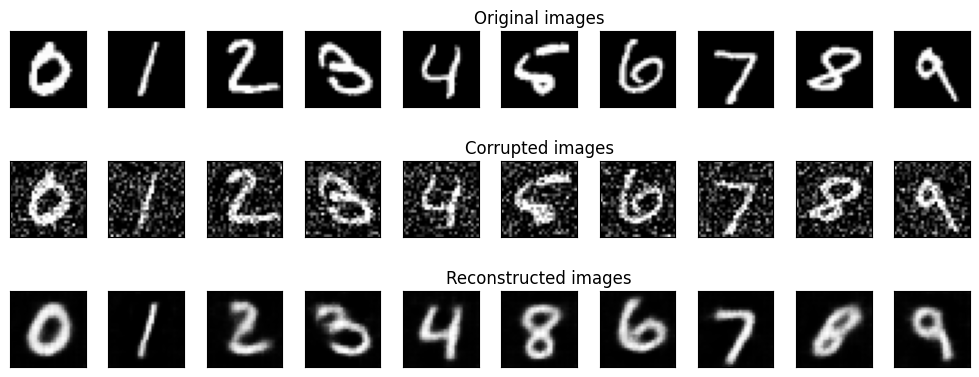

EPOCH  16

 EPOCH 17/30 	 train loss 0.028 	 val loss 0.000


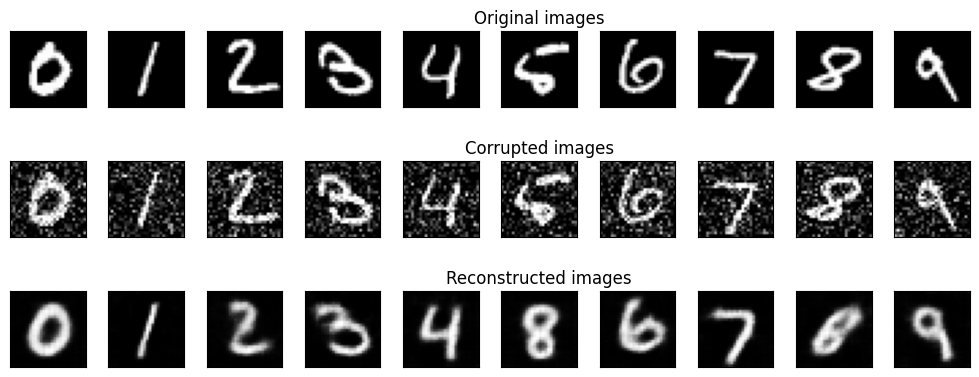

EPOCH  17

 EPOCH 18/30 	 train loss 0.028 	 val loss 0.000


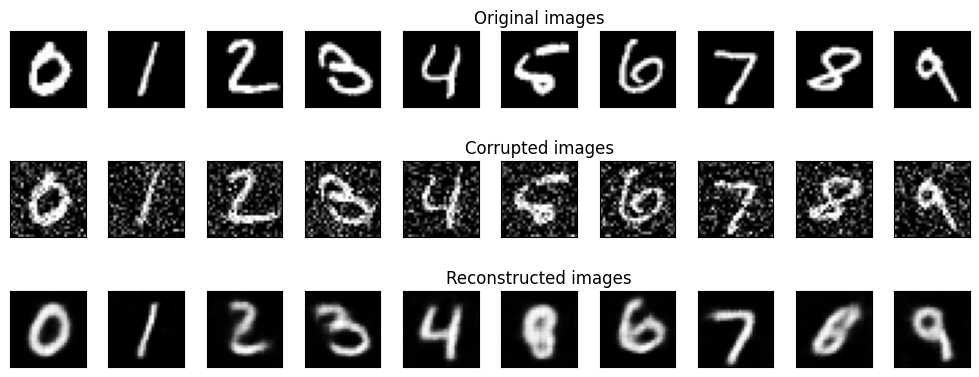

EPOCH  18

 EPOCH 19/30 	 train loss 0.028 	 val loss 0.000


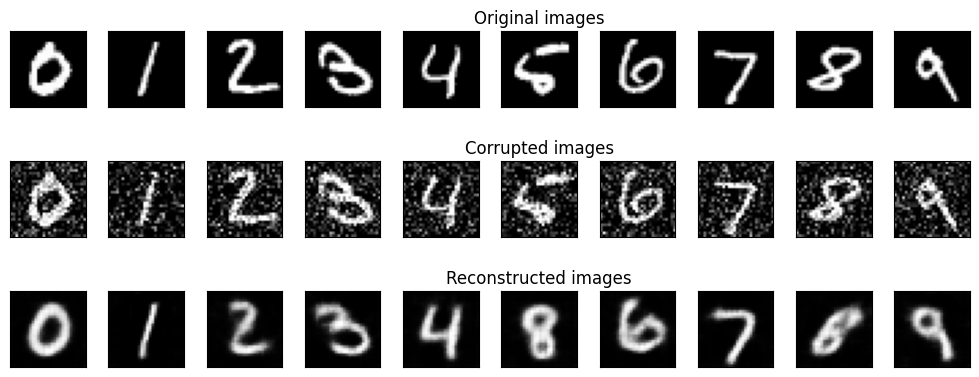

EPOCH  19

 EPOCH 20/30 	 train loss 0.028 	 val loss 0.000


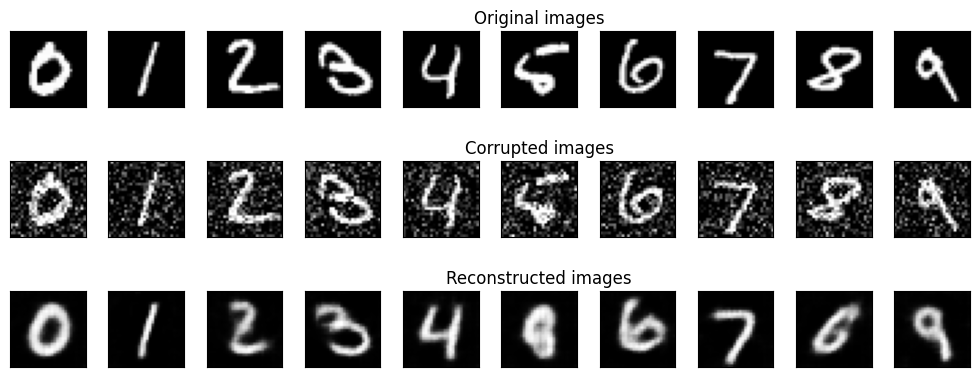

EPOCH  20

 EPOCH 21/30 	 train loss 0.028 	 val loss 0.000


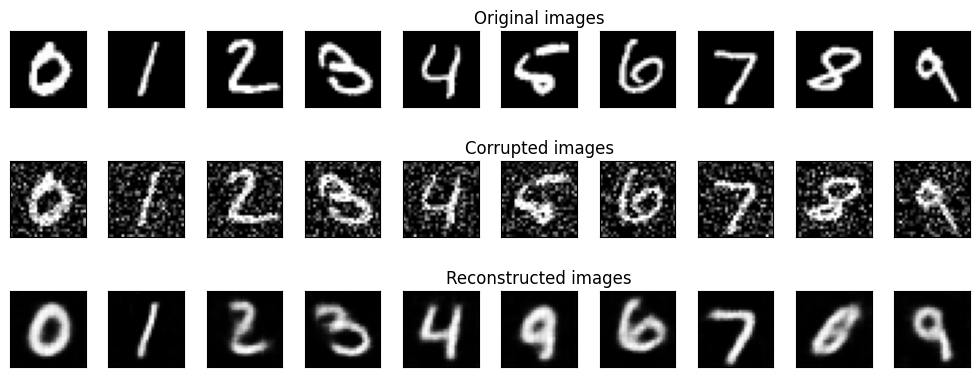

EPOCH  21

 EPOCH 22/30 	 train loss 0.027 	 val loss 0.000


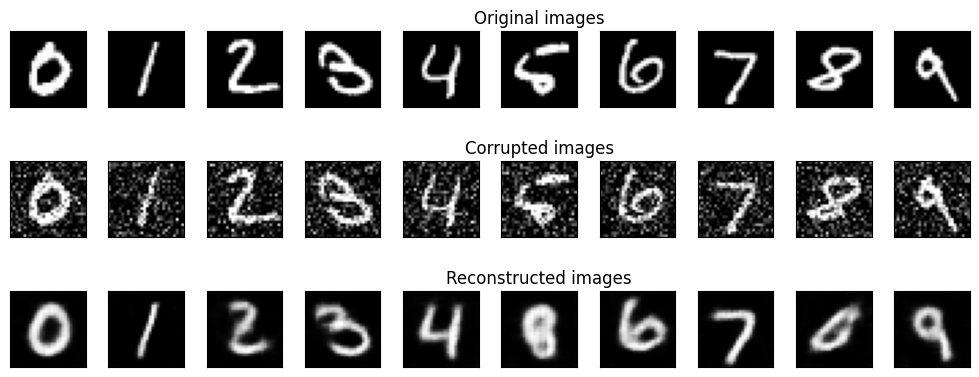

EPOCH  22

 EPOCH 23/30 	 train loss 0.027 	 val loss 0.000


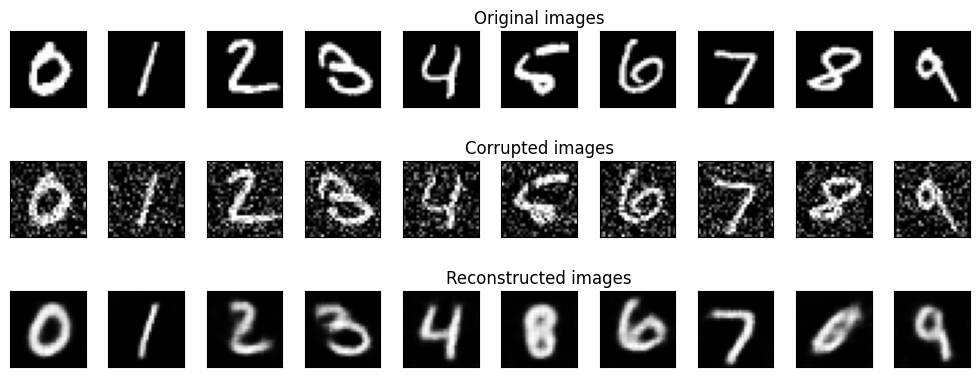

EPOCH  23

 EPOCH 24/30 	 train loss 0.027 	 val loss 0.000


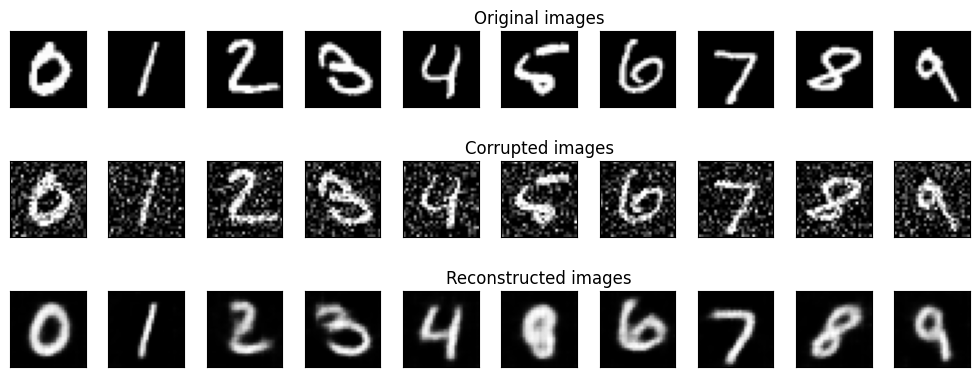

EPOCH  24

 EPOCH 25/30 	 train loss 0.027 	 val loss 0.000


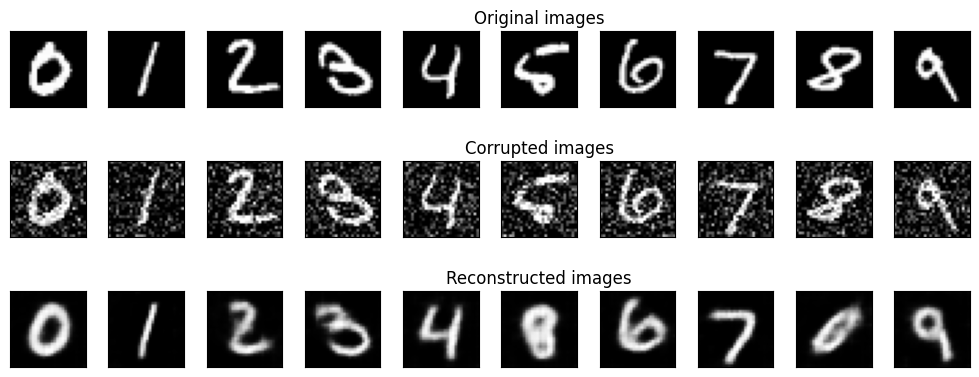

EPOCH  25

 EPOCH 26/30 	 train loss 0.027 	 val loss 0.000


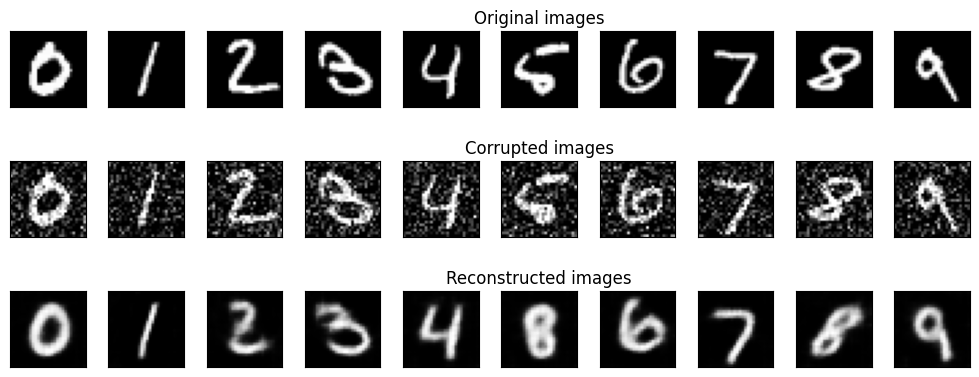

EPOCH  26

 EPOCH 27/30 	 train loss 0.027 	 val loss 0.000


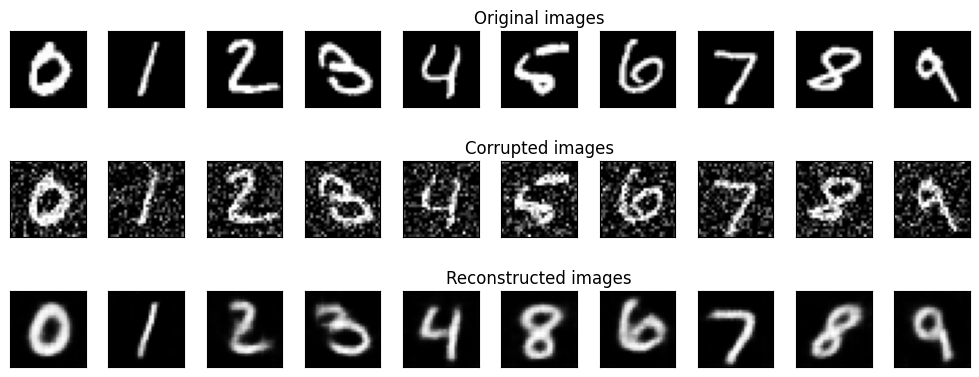

EPOCH  27

 EPOCH 28/30 	 train loss 0.027 	 val loss 0.000


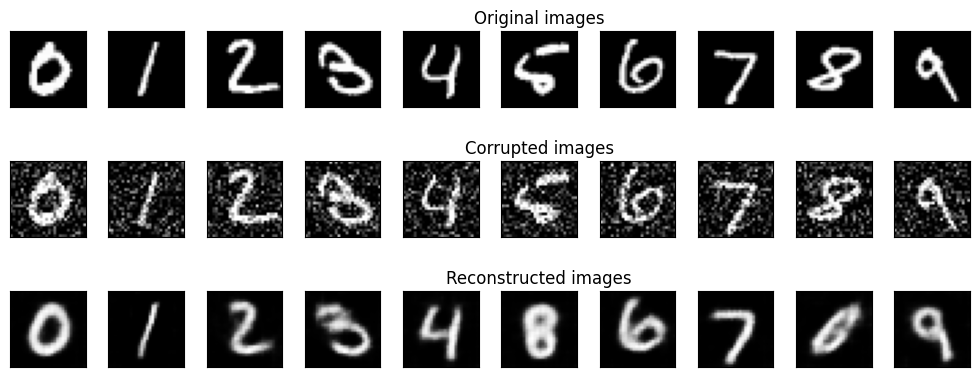

EPOCH  28

 EPOCH 29/30 	 train loss 0.027 	 val loss 0.000


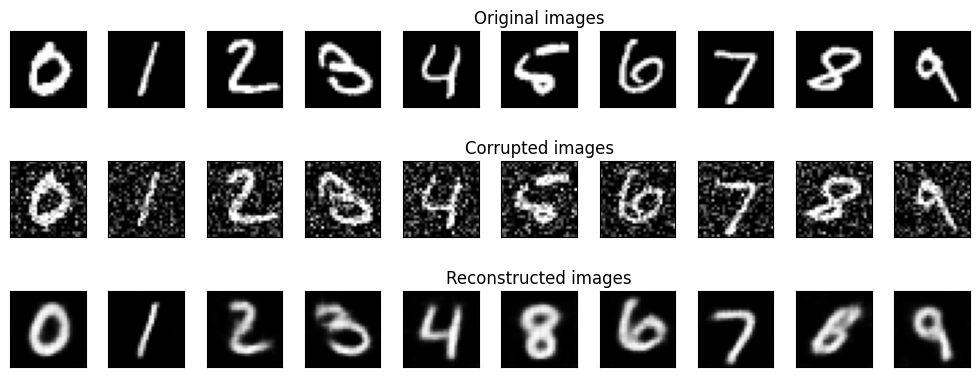

EPOCH  29

 EPOCH 30/30 	 train loss 0.027 	 val loss 0.000


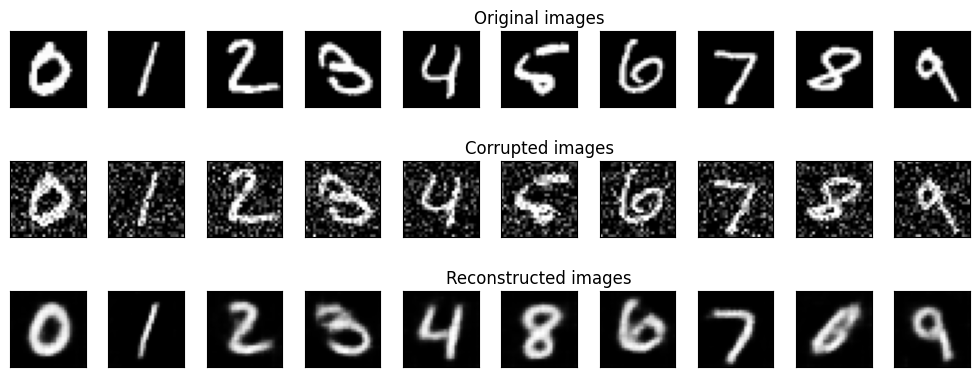

In [47]:
noise_factor = 0.3
num_epochs = 30
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs): 
    print('EPOCH ', epoch)

    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim, noise_factor)
    val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn, noise_factor)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


In [48]:
# Save models 
import pickle

# with open('./models/denoising_autoencoder/encoder.pkl', 'wb') as f: 
#     pickle.dump(encoder, f)
# with open('./models/denoising_autoencoder/decoder.pkl', 'wb') as f: 
#     pickle.dump(decoder, f)

mean tensor([-0.1390,  0.0729,  0.1170, -0.0552]) std tensor([0.7768, 0.7911, 0.5947, 0.6926])
latent tensor([[ 0.1130,  0.1480,  0.4302, -0.1463],
        [ 0.7355,  0.3584,  1.1730,  0.5031],
        [ 1.0559,  0.1638,  0.2552, -0.8470],
        [-1.0228, -0.8383, -0.0240,  0.6863],
        [ 0.1972, -1.5777,  0.7842,  0.8251],
        [-0.5342,  0.0769,  1.3600,  0.1436],
        [ 1.2938,  0.7236, -0.8918, -0.8212],
        [ 0.5086, -0.9483,  1.0947, -0.4966],
        [-0.3572, -0.8912, -0.8062,  0.6471],
        [ 0.2187, -0.6228, -0.0155, -0.5034],
        [ 0.0035,  0.5747, -0.5324,  0.4226],
        [-0.7427, -0.4804,  0.0216, -0.8432],
        [-1.3542, -0.6633,  0.2202, -1.3583],
        [ 0.5514, -0.4984,  0.7722,  0.3711],
        [-1.7659, -0.5758,  0.2771, -1.4612],
        [-1.2708, -0.3266,  0.8538,  0.0894],
        [ 0.2204,  0.9929,  0.6130,  0.1462],
        [-0.4414,  0.7277,  1.2141, -0.2271],
        [-0.4671,  0.2704, -0.1417,  1.1597],
        [-0.0695, -0.049

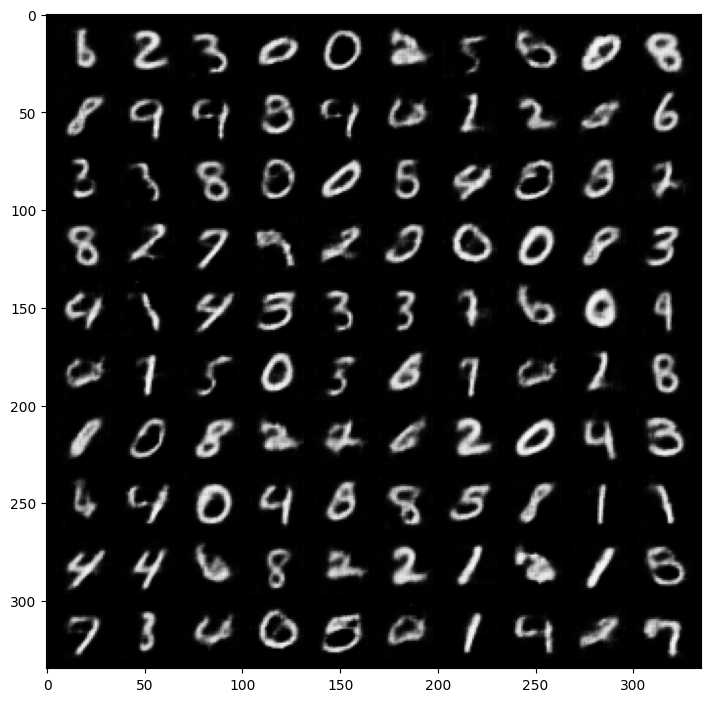

In [49]:
def show_image(img): 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad(): 

    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print("mean", mean, "std", std)

    # Sample latent vectors from the normal dist 
    latent = torch.randn(128, d)*std + mean
    print("latent", latent)

    latent = latent.to(device)
    img_recon = decoder(latent).cpu()
    
    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))
    plt.show()
    

In [50]:
from tqdm import tqdm
# Visualize the latent space 
encoded_samples = []
for sample in tqdm(test_dataset): 
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]

    encoder.eval()
    with torch.no_grad():
        encoded_img = encoder(img)
    
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:13<00:00, 767.97it/s]


In [51]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()